In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
from astropy.io import fits
from matplotlib.colors import SymLogNorm, Normalize
from PIL import Image

In [3]:
original = fits.open('/home/aalvarez/Work/Data/sim11/histo.fits')[0].data
original.shape

(24, 24)

In [4]:
sourcex = fits.open('/home/aalvarez/Work/Data/sim11/check_background.fits')[0].data

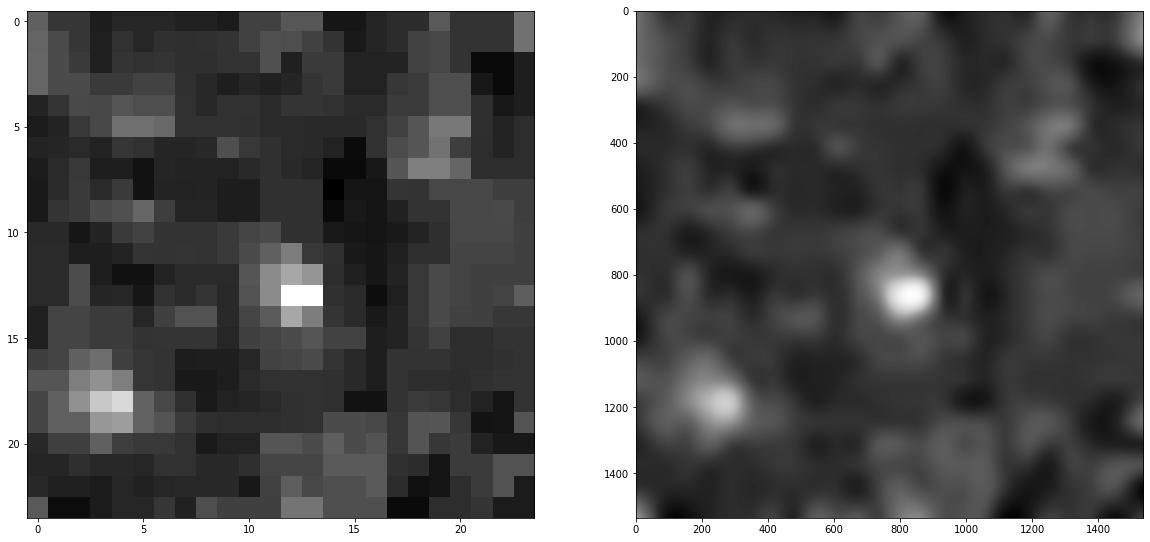

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes[0].imshow(original, cmap='Greys_r')
axes[1].imshow(sourcex, cmap='Greys_r')
plt.show()

## 1D interpolation

In [6]:
def myinterpolate(y, newsize):
    # https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation
    # For inversion: https://en.wikipedia.org/wiki/Tridiagonal_matrix
    size = len(y)
    result = np.zeros(newsize)
    
    # Consider x = 0:n:1
    # The new x is -1/2s:new+1/2s:1/s
    s = size / newsize
    
    # h[i] = x[i] - x[i-1], but since pixels are equally spaced, all h_i are 1, so we skip them
    # u[i] = h[i] / (h[i] + h[i+1]), which is always 1/2
    # l[i] = 1 - u[i], which, again, is always 1/2
    u = 0.5
    l = 0.5
       
    d = np.zeros(size)
    # By definition of natural cubic spline, second derivative is 0
    d[0] = d[-1] = 0.
    # X is equally spaced with width 1, so x[i] - x[i-1] 
    d[1:-1] = 6 * ((y[2:] - y[1:-1]) - (y[1:-1] - y[:-2])) / 2
        
    # From https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation
    # We now use a matrix A, where the diagonal is 2, the lower diagonal is u[n], and the upper diagonal l[n]
    # The rest is 0
    # Therefore, we can just apply the Tridiagonal matrix algorithm to solve the system
    # A x M = d
    # We do not need the full matrix. As a matter of fact, we do not even need arrays, as all $\lambda_i$ and $\mu_i$ have the same
    # values except if i = 0
    # @see https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    
    # Forward sweep
    M = np.zeros(size)
    B = np.full(size, 2.)
    for i in range(1, size):
        a = u if i < size - 1 else 0
        c = l if i > 1 else 0
        W = a / B[i-1]
        B[i] = B[i] - W * c
        d[i] = d[i] - W * d[i-1]

    # Back substitution
    M[-1] = d[-1] / B[-1]
    for i in range(size - 2, -1, -1):
        c = l if i > 1 else 0
        M[i] = (d[i] - c * M[i + 1]) / B[i]
    
    # M is always divided by 6 on formula 1 since h[i] is 1
    M /= 6
    
    # We have actually done the interpolation on the range 0:n, where n+1 is the total size of the original data.
    # Our new pixel coordinates are resampled on the range 0.5:n-0.5, as the center of the first interval must be aligned
    # with the first original value, and the center of the last inverval with the last value
    # Visually: the X are the original values (size 3), the dots (X included) are the new values (size 15)
    #
    # |..X..|..X..|..X..|
    #
    newx = np.linspace(-0.5, size - 0.5, newsize)
    
    for ni, nx in enumerate(newx):
        # i is a proxy for x[i]
        i = int(nx) + 1
        if i > size-1:
            i = size-1
        result[ni] =   M[i-1] * (i - nx)**3 \
                    + M[i]  * (nx - (i-1))**3 \
                    + (y[i-1] - M[i-1]) * (i - nx) \
                    + (y[i] - M[i]) * (nx - (i-1))
        
    return result

In [7]:
def interpolate(y, newsize):
    s = newsize / len(y)
    s/=2
    x = np.linspace(s, newsize-s, len(y), dtype=np.float)
    nx = np.arange(0, newsize)
    return scipy.interpolate.interp1d(x, y, 'cubic', bounds_error=False, fill_value='extrapolate')(nx)

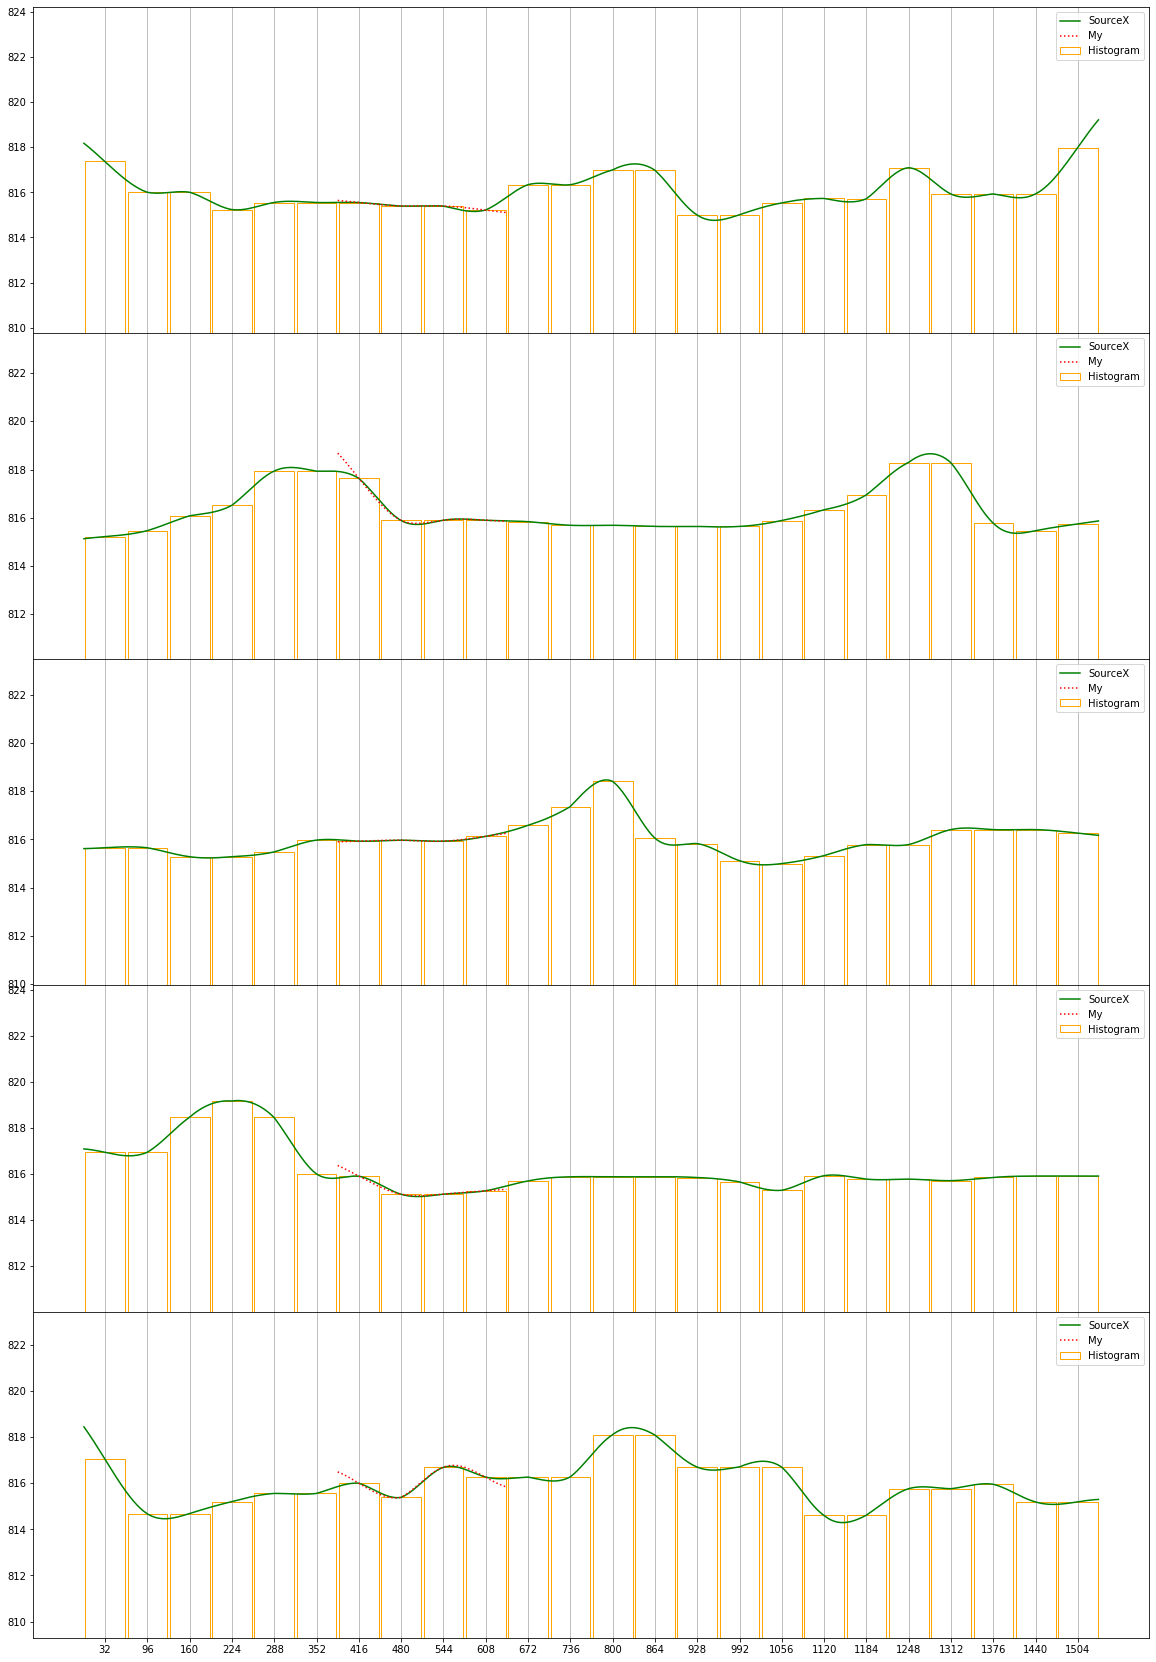

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20,30), sharex=True)
plt.subplots_adjust(hspace=0)

rows = np.linspace(0, original.shape[0]-1, len(axes), dtype=np.int)

for i, ax in enumerate(axes):
    r = rows[i]
    data_y = original[r,:]
    data_x = np.arange(len(data_y))
    
    sx = sourcex[r*64+32,:]
    sxx = np.arange(len(sx))
    
    #scinew = interpolate(data_y[:-2], len(sxx)-64*2)
    suby = data_y[6:10]
    mynew = myinterpolate(suby, len(suby)*64)
    
    ax.bar(data_x*64+32, data_y, width=60, label='Histogram', edgecolor='orange', fill=None)
    ax.plot(sxx, sx, label='SourceX', c='g')
    #ax.plot(sxx[:len(scinew)], scinew, label='SciPy', c='r')
    ax.plot(sxx[:len(mynew)]+6*64, mynew, label='My', c='r', linestyle=':')
    ax.set_ylim(np.min(sx)-5, np.max(sx)+5)
    ax.set_xticks(np.arange(32, np.max(sxx), 64))
    ax.xaxis.grid(True)

    ax.legend()

plt.show()

## 2D interpolation

In [113]:
cell_size = 64
newsize = original.shape[0]*cell_size, original.shape[1]*cell_size

In [114]:
img = np.zeros(newsize)
for i in range(original.shape[0]):
    img[i*cell_size,:] = myinterpolate(original[i,:], newsize[1])
for i in range(img.shape[1]):
    img[:, i] = myinterpolate(img[::cell_size, i], newsize[0])

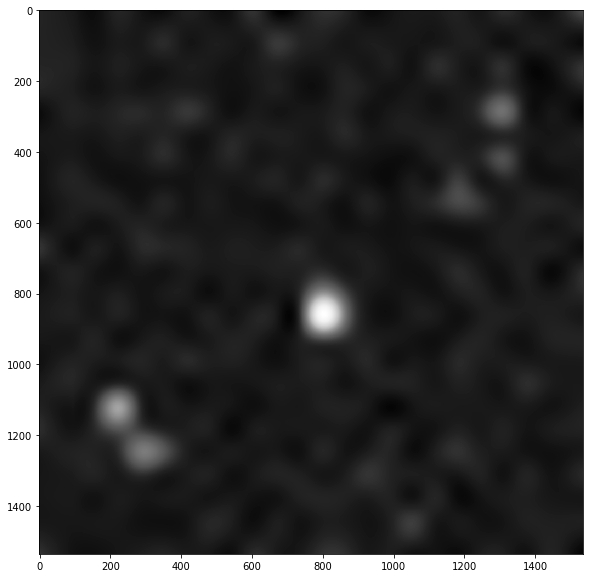

In [115]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='Greys_r')
plt.show()

# Compare with other implementations

In [116]:
from PIL.Image import Image, BICUBIC, fromarray

In [126]:
sx = newsize[0] / (2*original.shape[0])
sy = newsize[1] / (2*original.shape[1])

ox = np.linspace(sx, newsize[0]-sx, original.shape[0], dtype=np.float)
oy = np.linspace(sy, newsize[1]-sy, original.shape[1], dtype=np.float)
nx = np.arange(0, newsize[0])
ny = np.arange(0, newsize[1])


resized_dict = {'my': img}
resized_dict['scipy'] = scipy.interpolate.interp2d(ox, oy, original, kind='cubic', bounds_error=False, fill_value=None)(nx, ny)
resized_dict['pil'] = np.array(fromarray(original).resize((newsize[0], newsize[1]), BICUBIC))
resized_dict['sourcex'] = sourcex

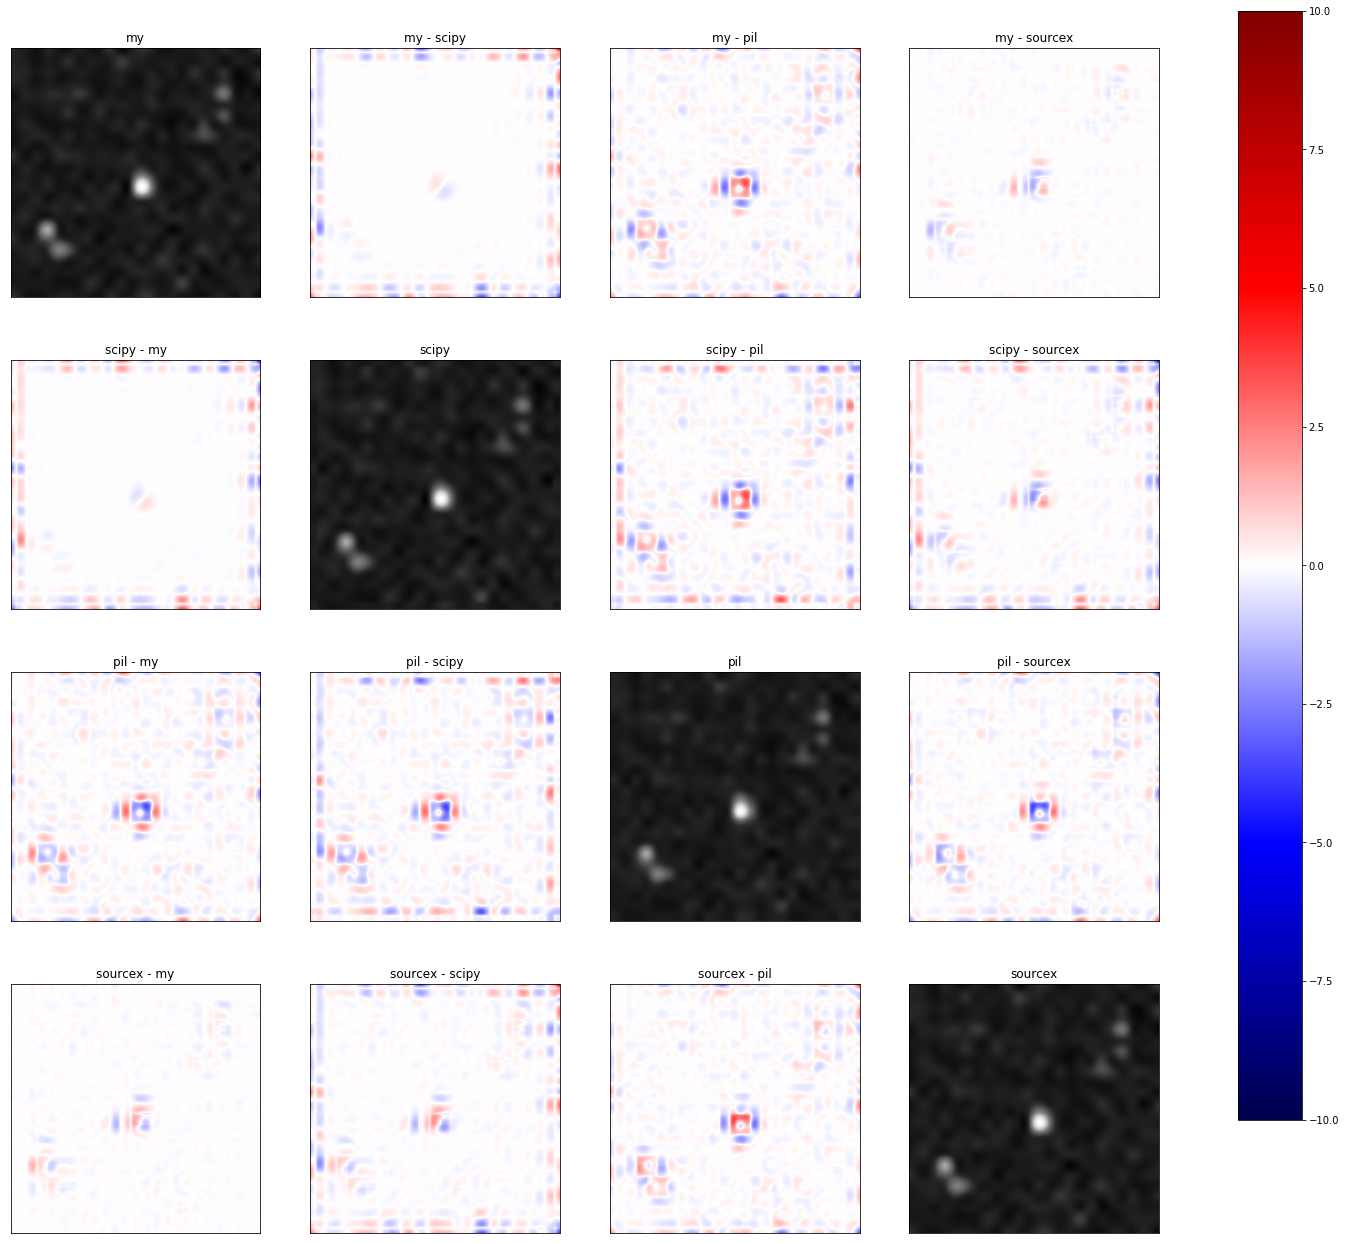

In [127]:
img_norm = SymLogNorm(10)
diff_norm = Normalize(vmax=10, vmin=-10)

nimages = len(resized_dict)
fig, axes = plt.subplots(nimages, nimages, figsize=(22, 22), sharex=True, sharey=True)
for i, (ref_label, ref) in enumerate(resized_dict.items()):
    for j, (target_label, target) in enumerate(resized_dict.items()):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if i == j:
            axes[i, j].imshow(ref, cmap='Greys_r', norm=img_norm)
            axes[i, j].set_title(ref_label)
        else:
            d = axes[i, j].imshow(ref - target, cmap='seismic', norm=diff_norm)
            axes[i, j].set_title(f'{ref_label} - {target_label}')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.2, 0.04, 0.7])
fig.colorbar(d, cax=cbar_ax)

plt.show()

# Write

In [14]:
from astropy.io import fits

In [15]:
fits.PrimaryHDU(img).writeto('bg_scaled.fits', overwrite=True)

# Notes
There is a cubic spline interpolator in Alexandria, but I think it uses the same method I was using before, which conserves f(x) and f'(x), but does not respect
f''(x).

From what I understand of SourceXtractor code, and from some initial tests, I need to use the procedure that respects f''(x).
What to do? Shall I add this to SourceX, add to Alexandria as an additional method, modify the one in Alexandria...?

Additionally, I think for rescaling the image we can save some resources, as dx is always 1 for images.

In [ ]:
Wha